<a href="https://colab.research.google.com/github/shawk17/563-shawk17/blob/main/Lattice_mc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lattice MC
* impolement square-lattice
* particles to sit on a grid
* calculate the energy of your grid
* trial moves that implement detailed balance
* have pbc
  * The effect of the interface increases the less particles you have. PBC helps alliviate this effect.
$$P_{\text{rand part}} * P_{\text{choose empty site next to another particle}} * \exp(-ΔE/kT)$$

### I used ChatGTP to help fix my code
I had an error in the code (see the bottom of the page), so I ended up getting rid of the particle class and used ChatGTP to help fix this code, then I added a bunch of things (like the different move types, graphing, different temperatures, ect)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

class Grid:
    def __init__(self, L, N, kT=1, move_type = 'step'):
        # Grid setup
        self.L = L
        self.grid = np.zeros((L, L), dtype=int)
        self.particles = []  # List of particle coordinates [(x1, y1), (x2, y2), ...]
        self.populate(N)
        self.neighbor_locs = [[0, 1], [0, -1], [1, 0], [-1, 0]]
        self.energy = self.get_energy()
        self.kT = kT
        self.energies = [self.energy]
        self.move_type = move_type

    def populate(self, N):
      """Efficiently populate the grid with N particles."""
      # Generate all possible grid positions and shuffle them
      positions = [(x, y) for x in range(self.L) for y in range(self.L)]
      random.shuffle(positions)

      # Select the first N positions and populate the grid
      for x, y in positions[:N]:
          self.grid[x, y] = 1
          self.particles.append((x, y))


    def get_neighbors(self, x, y):
        """Get the neighboring grid values for a given particle position."""
        neighbors = []
        for loc in self.neighbor_locs:
            nx = (x + loc[0]) % self.L
            ny = (y + loc[1]) % self.L
            neighbors.append(self.grid[nx, ny])
        return neighbors

    def update_grid(self):
        """Update the grid based on particle positions."""
        self.grid = np.zeros((self.L, self.L), dtype=int)
        for x, y in self.particles:
            self.grid[x, y] = 1

    def get_energy(self):
        """Calculate the energy of the current microstate."""
        energy = 0
        for x, y in self.particles:
            neighbors = self.get_neighbors(x, y)
            energy += -sum(neighbors)  # Interaction energy
        return energy

    def get_random_loc(self):
        """Get a random location for a particle to move to."""
        if self.move_type == 'step':
            return random.choice(self.neighbor_locs)
        elif self.move_type == 'random':
            return [random.randint(0, self.L-1), random.randint(0, self.L-1)]
        else:
            raise ValueError("Invalid move type. Must be 'step' or 'random'.")

    def try_move(self):
        """Attempt to move a randomly chosen particle."""
        move = self.get_random_loc()
        new_particles = copy.deepcopy(self.particles)

        # Select a random particle to move
        particle_index = np.random.randint(len(new_particles))
        x, y = new_particles[particle_index]

        # Compute new position with periodic boundary conditions
        new_x = (x + move[0]) % self.L
        new_y = (y + move[1]) % self.L

        # Check if the new position is occupied
        if self.grid[new_x, new_y] == 1:
            return False

        # Update the particle position
        new_particles[particle_index] = (new_x, new_y)

        # Calculate the energy change
        new_energy = self.get_energy_with_particles(new_particles)
        delta_E = new_energy - self.energy

        # Accept or reject the move
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / self.kT):
            self.particles = new_particles
            self.energy = new_energy
            self.update_grid()
            return True
        return False

    def get_energy_with_particles(self, particles):
        """Calculate energy for a given particle configuration."""
        energy = 0
        for x, y in particles:
            neighbors = self.get_neighbors(x, y)
            energy += -sum(neighbors)
        return energy

    def simulate(self, t=1000):
        """Run the simulation for t steps."""
        for _ in range(t):
            self.try_move()
            self.energies.append(self.energy)
        return self.energies





In [5]:
kT = [0.1,0.4, 0.5, 0.6,0.7, 1, 2, 5]
kT = [0.1]
average = 1
move_types = ['random', 'step']
N = 20
L = 7
all_energies = {}

for move_type in move_types:
  for T in kT:
    print(f'kT = {T}, move type = {move_type}')
    total_energy = []

    for i in range(average):
      grid_step = Grid(L, N, kT = T, move_type = move_type)
      energies = grid_step.simulate(t = 2000)
      total_energy.append(energies)

    energies = np.mean(total_energy/(2*N), axis = 0)

    # Plotting
    all_energies[f'kT = {T}, {move_type}'] = energies



kT = 0.1, move type = random
kT = 0.1, move type = step


[[0 0 0 1 0 1 0]
 [1 0 0 1 1 1 1]
 [1 0 0 1 1 1 1]
 [1 1 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [1 1 0 0 0 0 0]]


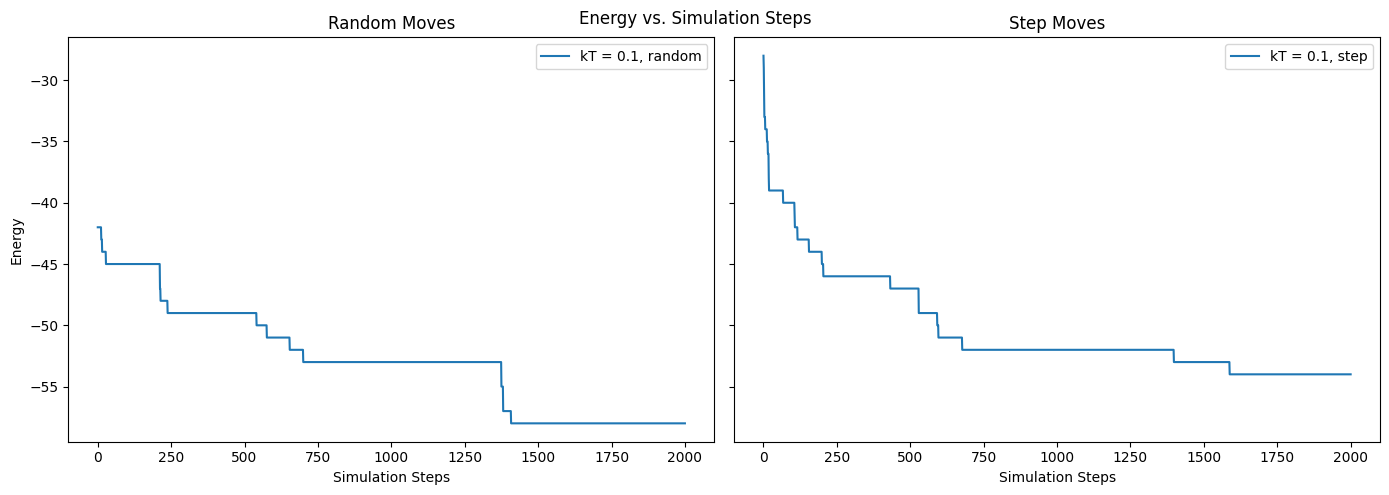

In [7]:
# Graph with subplots
print(grid_step.grid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey = True)

for energy_label in all_energies:
    energies = all_energies[energy_label]

    if 'random' in energy_label:
        ax1.plot(energies, label=energy_label)
        ax1.set_title('Random Moves')
    else:
        ax2.plot(energies, label=energy_label)
        ax2.set_title('Step Moves')

# Add labels, legends, and a shared y-axis label
ax1.set_xlabel('Simulation Steps')
ax1.set_ylabel('Energy')
ax1.legend()

ax2.set_xlabel('Simulation Steps')
ax2.legend()

plt.tight_layout()
plt.suptitle('Energy vs. Simulation Steps')
plt.show()

## Analysis
* Moving to a random spot on the grid seems to find lower energies than moving 1 step at a time. As well as equilibrating faster (getting to a constant energy). I am assuming the same temperatures should equilibrate to the same values eventually?
* 0.1 kT rarely if ever goes to a higher energy, it seems to be on a steady downward trend.
* 5 kT seems to accept almost every move, increasing the kT doesn't change it much.
* Between 0.4 and 1 kT there is a large difference, is this related to something like a melting temperature?
* The plots look almost the exact same at a larger system size (L=10, N=20 vs L=20, N = 40), it also took about twice as long to run.
* The high temperatures I am pretty certain are equilibrated, but the low temperatures (0.1, 0.4 kT) still seem to be dropping.
* There are probably better ways to calculate the energy so the total runtime would scale O(1), or just based on the number of time steps, but the way I am currently doing it, it seems to scale O(N*L), as changing both number of particles and length by a factor of 2 just about doubles the simulation time.
## Future Work
It would be interesting to keep track of the particle islands at different temperatures, densities, and move types. There is a lot of work to make this code more efficient (ie calculate the energy change by just looking at the particle that moved and not the whole system). It would also be nice to learn how to implement a code that just looks at moving to open spots, instead of moving to any spot. Also I should probably run for more equilibration steps so the lower temperatures can equilibrate.


### Errors Below
This was my first attempt, I ran into to many errors, so I had ChatGTP help me rewrite it.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy


class Grid:
  def __init__(self, L,  N, kT = 1):
    # Grid
    self.L = L
    self.grid = np.zeros((L, L))
    self.populate(N)
    self.update_grid()
    self.neighbor_locs = [[0,1],[0,-1],[1,0],[-1,0]]
    self.energy = self.get_energy()
    self.kT = kT
    self.energies = [self.energy]

  # Particles
  def populate(self, N):
    self.N = []
    for i in range(N):
      while True: # This can be better, maybe using pop
        x = np.random.randint(0, self.L)
        y = np.random.randint(0, self.L)
        if self.grid[x, y] == 0:
          self.grid[x, y] = 1
          self.N.append(Particle(x, y, self))
          break

  def get_neighbors(self):
    neighbors = []
    for loc in self.neighbor_locs:
      neighbors.append(self.system.grid[(self.x + loc[0]) % self.system.L, (self.y + loc[1]) % self.system.L])
    return neighbors

  def update_grid(self):
    self.grid = np.zeros((self.L, self.L))
    for n in self.N:
      self.grid[n.x, n.y] = n.id

  # calc energy of a configuarion (microstate)
  def get_energy(self, N = False):
    if not N:
      N = self.N

    energy = 0
    for n in N:
      energy += sum(n.get_neighbors())*(-1)
    return energy

  def get_particle_energy(self, n):
    energy += sum(n.get_neighbors)*n.energy
    return energy

  def try_move(self):
    # Make a new config
    direction = random.choice(self.neighbor_locs)
    N_new = copy.deepcopy(self.N)
    for n in N_new:
      n.system = self
    n = np.random.choice(N_new) # Probability of choosing a particle
    n.x = (n.x + direction[0]) % self.L
    n.y = (n.y + direction[1]) % self.L
    if not self.grid[n.x, n.y] == 0:
      return False
    else:
      # Calculate Energy
      # Calculate delta E
      # Accept or reject
      new_energy = self.get_energy(N_new)
      delta_E = new_energy - self.energy
      if delta_E < 0:
        self.energy = new_energy
        self.N = N_new
        self.update_grid()
        return True
      elif np.random.rand() < np.exp(-delta_E/self.kT):
        #print(delta_E)
        self.energy = new_energy
        self.N = N_new
        self.update_grid()
        return True
      else:
        return False

  def simulate(self, t = 1000):
    for i in range(t):
      self.try_move()
      self.energies.append(self.energy)
    return self.grid

In [ ]:
grid = Grid(3, 3, kT = 0.04)
grid.grid = np.array([[0,1,0],[0,1,0],[0,0,1]])
print(grid.grid)
print(grid.get_energy())
print(grid.simulate(t = 10))
print(grid.get_energy())
plt.plot(grid.energies)
plt.show()